In [5]:
import sklearn
import numpy as np
from tensorflow import keras
from explainer.metrics import draw_network, metrics, markov_blanket
from pgmpy.utils import get_example_model
import wandb
import copy
from ucimlrepo import fetch_ucirepo
from lime.lime_tabular import LimeTabularExplainer
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import re

In [7]:
wandb.login()

True

#### Data

In [ ]:
national_poll_on_healthy_aging_npha = fetch_ucirepo(id = 936) 

X = national_poll_on_healthy_aging_npha.data.features.to_numpy()
y = national_poll_on_healthy_aging_npha.data.targets.to_numpy()

feature_names = list(national_poll_on_healthy_aging_npha.data.features.columns)
class_name = national_poll_on_healthy_aging_npha.data.targets.columns[0]

  0%|          | 0/37 [00:00<?, ?it/s]

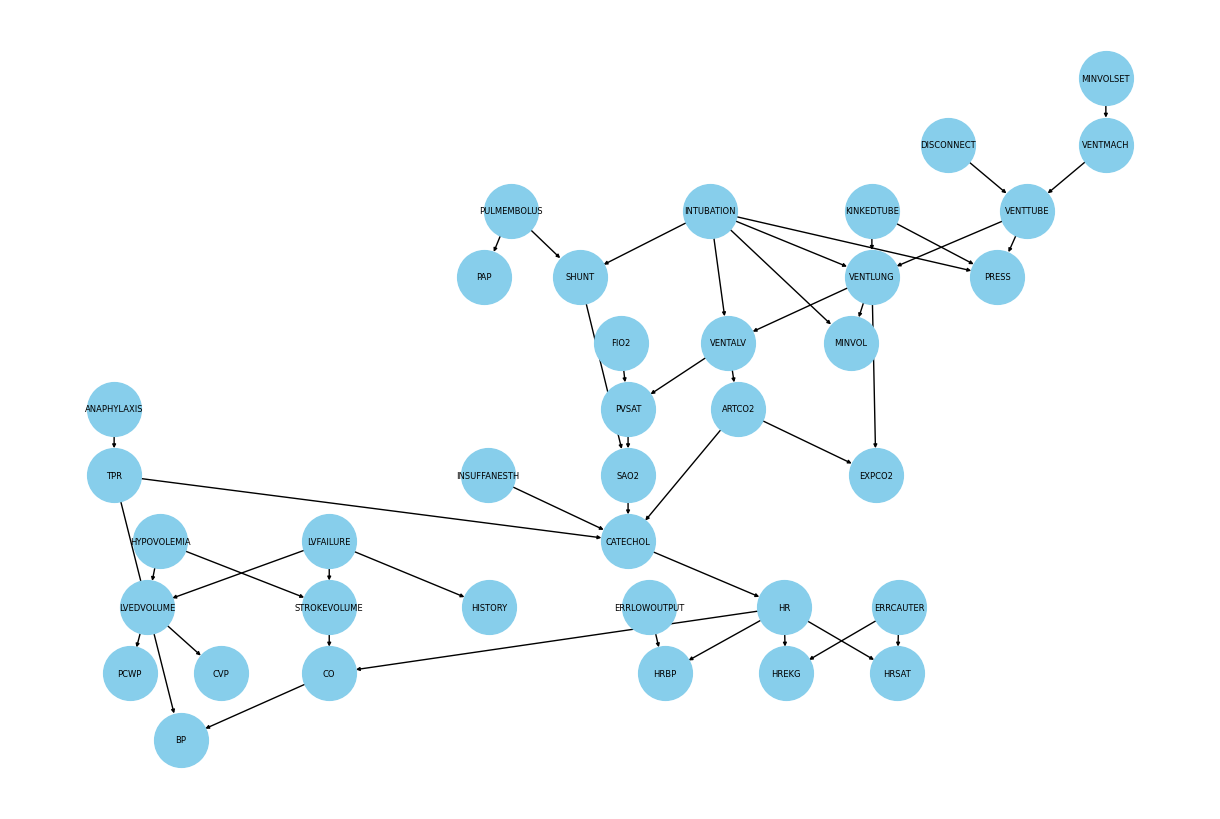

In [219]:
ground_bn = get_example_model("alarm")

dataset = ground_bn.simulate(n_samples = 1000)

draw_network(ground_bn)

In [180]:
feature_names = list(dataset.drop('HR', axis = 1).columns)
class_name = 'HR'

X = dataset.drop('HR', axis = 1).to_numpy()
y = dataset['HR'].to_numpy()

In [181]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X)

target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y.squeeze())

X = feature_encoder.transform(X)
y = target_encoder.transform(y)

#### Model

In [182]:
model = RandomForestClassifier(random_state = 0)
model.fit(X, y.squeeze())

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Feature Attribution

In [183]:
import itertools
import numpy as np
import pandas as pd
from pgmpy.base import PDAG
from pgmpy.estimators import PC, HillClimbSearch, ExpertKnowledge
from mlxtend.frequent_patterns import fpgrowth, association_rules
from scipy.stats import chi2_contingency
import pandas as pd

In [184]:
class Explainer:
    
    def __init__(self, model, X, feature_names, target_name, n_samples = 100, rep_prob = 0.5):
        
        self.X = X
        
        self.x_cols = feature_names
        self.y_col = target_name
        
        self.model = model
        
        self.n_samples = n_samples
        self.rep_prob = rep_prob
        
        self.data = None
        self.blanket = None
        self.dag = None
        
    def data_generation(self, x):
        
        y = self.model.predict(x.reshape(1, -1)).squeeze(0)
        
        random_indices = np.random.randint(len(self.X), size = self.n_samples)
        samples_X_base = self.X[random_indices]
        
        replace_mask = np.random.rand(self.n_samples, samples_X_base.shape[1]) < self.rep_prob
        
        samples_X = np.where(replace_mask, x, samples_X_base)
                
        samples_Y = self.model.predict(samples_X)
                
        samples_Y_bool = samples_Y != y
        
        samples_X_bool = samples_X != x
        
        samples_X_int = samples_X_bool.astype(int)
        samples_Y_int = samples_Y_bool.astype(int)
        
        self.data = pd.DataFrame(samples_X_int, columns = self.x_cols)
        self.data[self.y_col] = samples_Y_int

    def structures(self):
        
        est = PC(self.data)
        
        dag = est.estimate(ci_test = "chi_square", return_type = "dag")

        self.dag = markov_blanket(dag, self.y_col)

        blanket = dag.get_markov_blanket(self.y_col)

        '''

        edge_strengths = {}

        for node in blanket:
        
            contingency_table = pd.crosstab(self.data[node], self.data[self.y_col])
        
            chi, p_value, _, _ = chi2_contingency(contingency_table)
        
            edge_strengths[node] = chi
        
        self.blanket = list(dict(sorted(edge_strengths.items(), key = lambda item: item[1], reverse = True)))
        '''
        
    def explain(self, x):
        
        self.data_generation(x)
        self.structures()

#### Variable Associations (RQ1)
##### Comparison of global associations

In [220]:
# try k2, bic-d & pc

In [207]:
explainer = Explainer(model, X, feature_names, class_name, 1000, 0.1)

In [215]:
explainer.explain(X[458])

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'PRESS': 'N', 'LVFAILURE': 'N', 'ARTCO2': 'N', 'ANAPHYLAXIS': 'N', 'HREKG': 'N', 'VENTMACH': 'N', 'SHUNT': 'N', 'LVEDVOLUME': 'N', 'TPR': 'N', 'VENTLUNG': 'N', 'BP': 'N', 'PVSAT': 'N', 'EXPCO2': 'N', 'MINVOL': 'N', 'PAP': 'N', 'HYPOVOLEMIA': 'N', 'CVP': 'N', 'FIO2': 'N', 'PULMEMBOLUS': 'N', 'CATECHOL': 'N', 'PCWP': 'N', 'SAO2': 'N', 'VENTTUBE': 'N', 'MINVOLSET': 'N', 'HISTORY': 'N', 'HRSAT': 'N', 'VENTALV': 'N', 'INTUBATION': 'N', 'ERRCAUTER': 'N', 'INSUFFANESTH': 'N', 'CO': 'N', 'HRBP': 'N', 'ERRLOWOUTPUT': 'N', 'KINKEDTUBE': 'N', 'STROKEVOLUME': 'N', 'DISCONNECT': 'N', 'HR': 'N'}


  0%|          | 0/5 [00:00<?, ?it/s]

Ground Markov Blanket: ['CATECHOL', 'CO', 'HRBP', 'ERRLOWOUTPUT', 'STROKEVOLUME', 'HRSAT', 'HREKG', 'ERRCAUTER'] 

Explainer Markov Blanket: ['CO', 'HRBP', 'ERRLOWOUTPUT', 'STROKEVOLUME', 'HRSAT', 'HREKG', 'ERRCAUTER'] 

Markov Blanket Accuracy: 8 / 9
Ground Markov Blanket: 



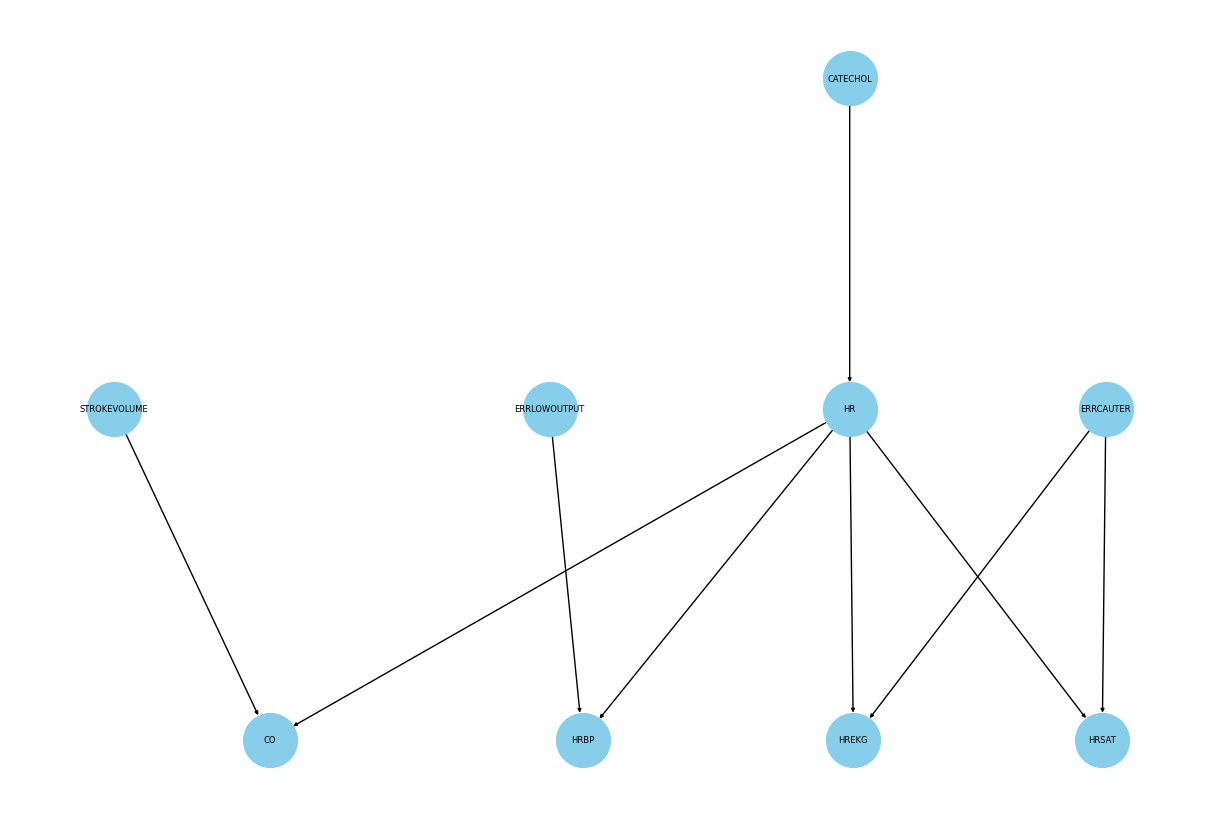

Explainer Markov Blanket: 



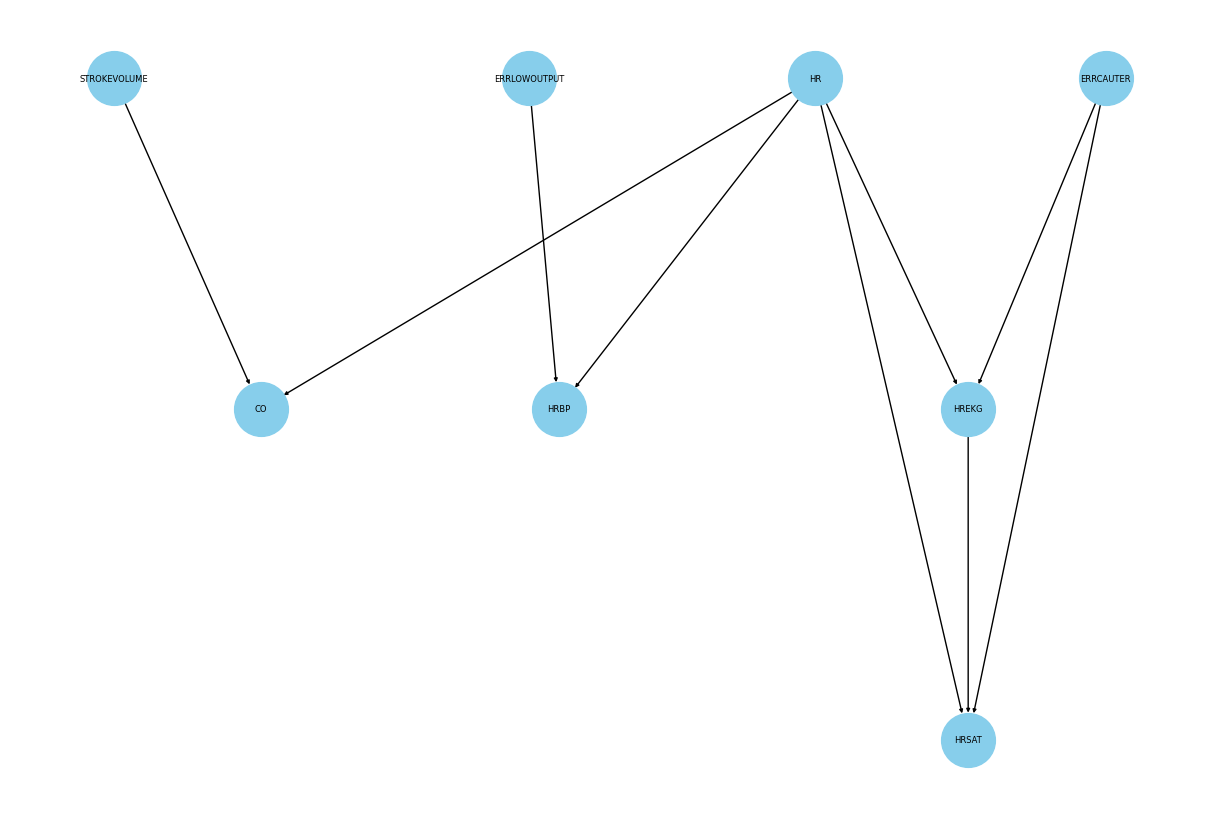

In [216]:
metrics(ground_bn, explainer.dag, explainer.y_col)

#### Feature Attribution (RQ2)
##### Comparison of feature relevance (not attribution)

In [170]:
def lime_attribution(instance, training_data, model, feature_names, class_name):

    explainer = LimeTabularExplainer(
        training_data = training_data,
        feature_names = feature_names,
        class_names = class_name,
        mode = 'classification'
    )

    exp = explainer.explain_instance(instance, model.predict_proba, num_features = len(feature_names))

    important_features = exp.as_list()
    sorted_features = [re.sub(r"[\d+\-*/<>.=() ]", "", feature) for feature, weight in sorted(important_features, key = lambda x: abs(x[1]), reverse = True)]

    return sorted_features

In [171]:
def explainer_attribution(instance, training_data, model, feature_names, class_name):
    
    explainer = Explainer(model, training_data, feature_names, class_name, n_samples = 1000, rep_prob = 0.1)

    explainer.explain(instance)

    return explainer.blanket